This is an extension off of Kaggle author, Rob Mulla's notebook found here:

https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet

# Objective: Predict hourly energy use from PJME Load Data.

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import fbprophet
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [7]:
pjme = pd.read_csv("PJME_hourly.csv",index_col=[0], parse_dates=[0])

## Initial Bird's Eye View

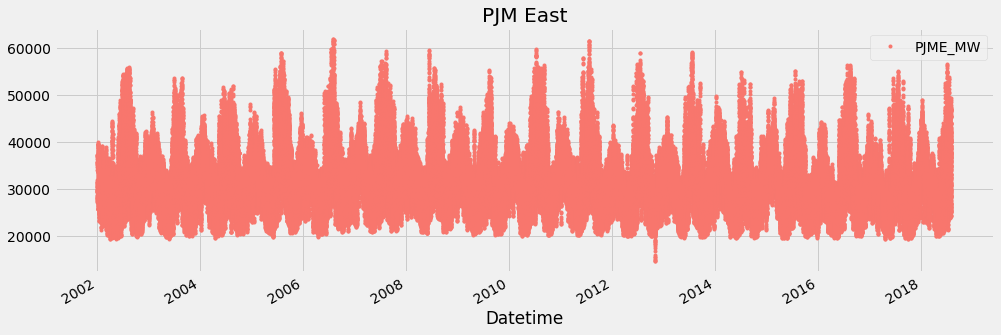

In [8]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

Between 2012 and 2014, we have a dip.

## EDA

Some preliminary rigid re-engineered time series features:

In [10]:
def create_features(df, label=None):
    """
    Creates time series features from datetime idx.
    """
    
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

In [11]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


## Plot Features to See Trends

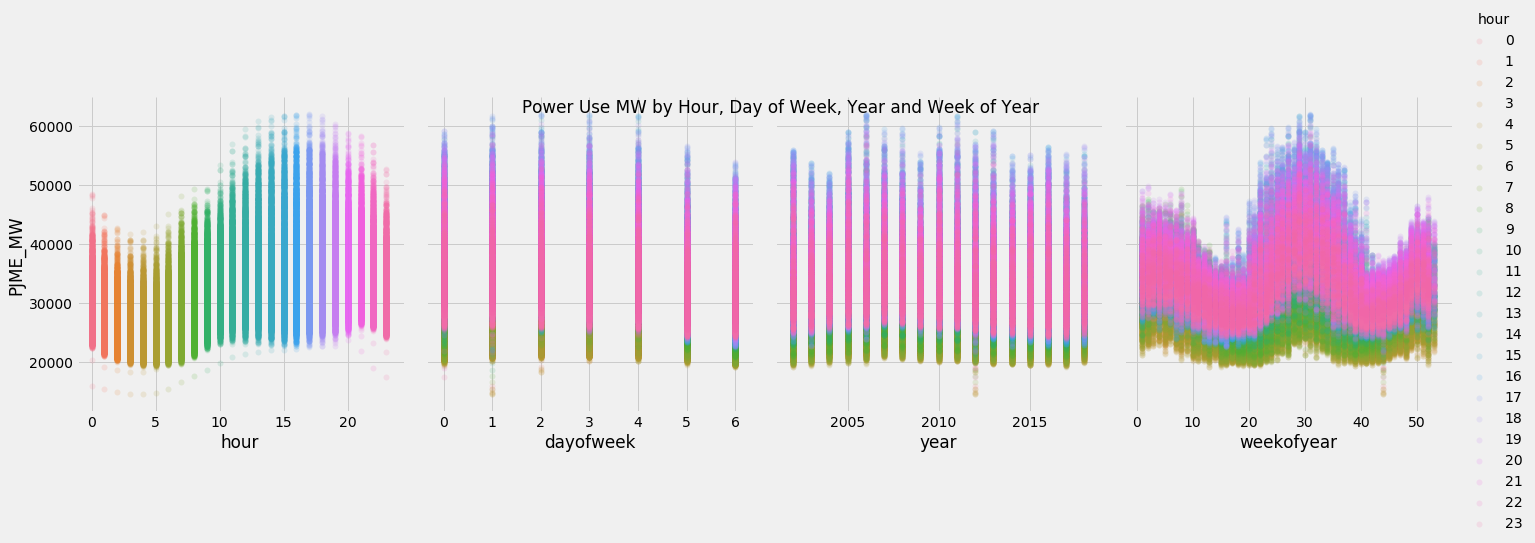

In [13]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

There are strong daily & seasonal properties. 

Day of week has different peaks.

## Train/Test Split

2015 is cut off for validation and test set.

In [15]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

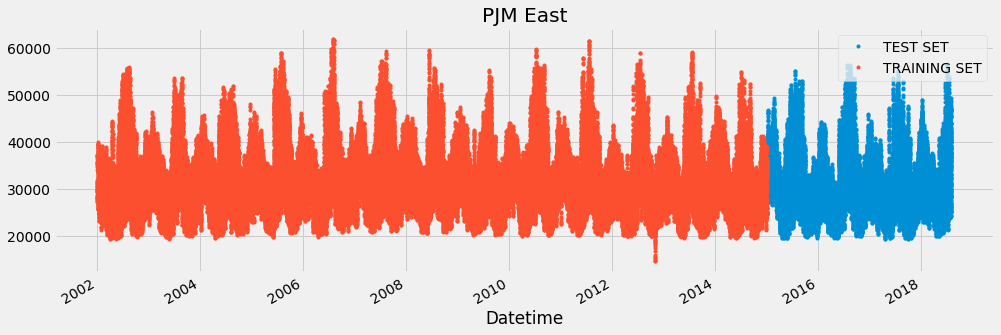

In [16]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

### Modeling with Prophet

In order to work with its model build algorithm, need to format data in a specific manner.

In [17]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'}).head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [20]:
# Setup and train model and fit

model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

In [21]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [23]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31207.063831,24188.336181,32740.876555,31207.063831,31207.063831,-2868.419002,-2868.419002,-2868.419002,-4430.402129,...,1281.405218,1281.405218,1281.405218,280.577909,280.577909,280.577909,0.0,0.0,0.0,28338.644829
1,2015-01-01 02:00:00,31207.026202,22075.163163,31491.909436,31207.026202,31207.026202,-4372.817968,-4372.817968,-4372.817968,-5927.333427,...,1272.645796,1272.645796,1272.645796,281.869663,281.869663,281.869663,0.0,0.0,0.0,26834.208234
2,2015-01-01 03:00:00,31206.988572,21526.922380,30228.331059,31206.988572,31206.988572,-5244.525171,-5244.525171,-5244.525171,-6790.408686,...,1262.680591,1262.680591,1262.680591,283.202924,283.202924,283.202924,0.0,0.0,0.0,25962.463401
3,2015-01-01 04:00:00,31206.950943,21308.435626,30216.769303,31206.950943,31206.950943,-5386.074750,-5386.074750,-5386.074750,-6922.285681,...,1251.633212,1251.633212,1251.633212,284.577718,284.577718,284.577718,0.0,0.0,0.0,25820.876192
4,2015-01-01 05:00:00,31206.913313,22177.173405,31236.278957,31206.913313,31206.913313,-4711.729010,-4711.729010,-4711.729010,-6237.362560,...,1239.639481,1239.639481,1239.639481,285.994069,285.994069,285.994069,0.0,0.0,0.0,26495.184303


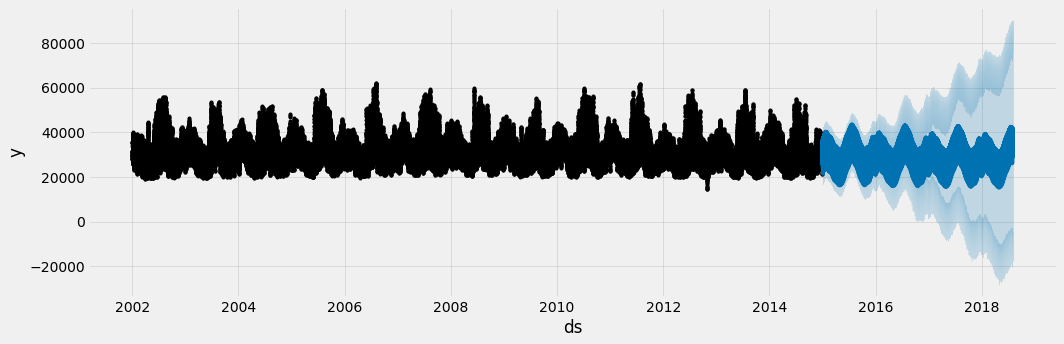

In [24]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

The dark and light blue is the forecast with different shades for different confidence intervals (95% or less).

In [53]:
# # Plot the components of the model
# fig = model.plot_components(pjme_test_fcst)

## Compare Forecast To Actuals

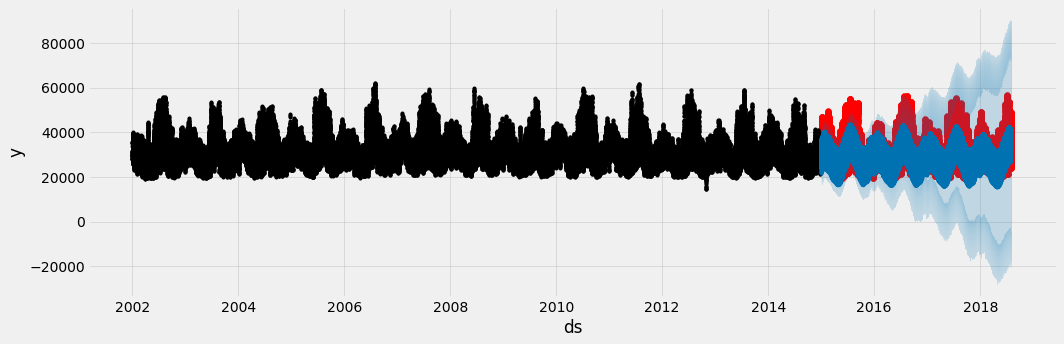

In [54]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

We can see that there is some error where prediction is not capturing higher MW actual values.

Let's zoom in and look at first month of predictions (January).

In [56]:
# Plot the forecast with the actuals
# f, ax = plt.subplots(1)
# f.set_figheight(5)
# f.set_figwidth(15)
# ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
# fig = model.plot(pjme_test_fcst, ax=ax)
# ax.set_xbound(lower='01-01-2015',
#               upper='02-01-2015')
# ax.set_ylim(0, 60000)
# plot = plt.suptitle('January 2015 Forecast vs Actuals')

We see here that there are relatively more errors between Jan 5th and Jan 12th. 

Let's Now look at a single week's predicitons.

In [60]:
# # Plot the forecast with the actuals
# f, ax = plt.subplots(1)
# f.set_figheight(5)
# f.set_figwidth(15)
# ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
# fig = model.plot(pjme_test_fcst, ax=ax)
# ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
# ax.set_ylim(0, 60000)
# plot = plt.suptitle('First Week of January Forecast vs Actuals')

## Error Metrics

These are picked from domain knowledge since original author of notebook was formerly in Power Industry.

In [64]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [67]:
predictions = pjme_test_fcst['yhat']
predictions

0        28338.644829
1        26834.208234
2        25962.463401
3        25820.876192
4        26495.184303
             ...     
31434    41319.234791
31435    40546.422174
31436    38917.169272
31437    36709.369789
31438    34383.735230
Name: yhat, Length: 31439, dtype: float64

In [73]:
targets = pjme_test.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'})['y']
targets

0        24305.0
1        23156.0
2        22514.0
3        22330.0
4        22773.0
          ...   
31434    44284.0
31435    43751.0
31436    42402.0
31437    40164.0
31438    38608.0
Name: y, Length: 31439, dtype: float64

In [77]:
rmse(predictions, targets)

6617.582523051443

In [78]:
mean_squared_error(targets,
                   predictions)

43792398.44939587

In [79]:
mean_absolute_error(targets,
                   predictions)

5182.773042911244

In [81]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [80]:
mean_absolute_percentage_error(targets,
                   predictions)

16.510175822754576

### Our RMSE error is 6617.58
### Our MSE error is 43792398.45
### Our MAE error is 5182.77
### Our MAPE error is 16.5%

Next step:
It would be to see Holidays' contribution to forecast (improve/not)?